## Classification of MNIST dataset with tensor networks

In [1]:
# import packages here
# --------------------------------------
import matplotlib.pyplot as plt

import qtealeaves as qtl
from qtealeaves.convergence_parameters.conv_params import TNConvergenceParameters
from qtealeaves.emulator.mps_simulator import MPS
from qtealeaves.emulator import StateVector

from tensorflow.keras.datasets import mnist
import numpy as np


2024-05-21 11:45:17.017635: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-21 11:45:17.021525: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-21 11:45:17.073075: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-21 11:45:17.074530: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-21 11:45:17.698386: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

### Load MNIST dataset

In [2]:
# Load dataset here
# --------------------------------------
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print(x_train.shape)
print(x_test.shape)


(60000, 28, 28)
(10000, 28, 28)


In [3]:
# Selecting only images with the numbers 3 and 8
train_filter = np.where((y_train == 3 ) | (y_train == 8))
test_filter = np.where((y_test == 3) | (y_test == 8))

x_train, y_train = x_train[train_filter], y_train[train_filter]
x_test, y_test = x_test[test_filter], y_test[test_filter]

train_idxs_3 = np.where(y_train == 3)
train_idxs_8 = np.where(y_train == 8)
test_idxs_3 = np.where(y_test == 3)
test_idxs_8 = np.where(y_test == 8)

y_train[train_idxs_3] = 0
y_train[train_idxs_8] = 1
y_test[test_idxs_3] = 0
y_test[test_idxs_8] = 1

# Reduce amount of images
nr_images = 500

x_train, y_train, x_test, y_test = x_train[:nr_images, :, :], y_train[:nr_images], x_test[:nr_images, :, :], y_test[:nr_images]

x_train = x_train / 255
x_test = x_test / 255

In [4]:
def encoding1(array: np.array):
    new_array = np.zeros((array.shape[0],2))
    for i in range(len(array)):
        p_i = np.sqrt(array[i])
        new_array[i] = (np.sqrt(1-np.square(p_i)), p_i)
    foo2 = np.expand_dims(new_array, axis = (1, -1))
    foo3 = []
    for i in range(foo2.shape[0]):
        foo3.append(foo2[i, :, :, :])
    return foo3

# Testing
foo = np.random.rand(16)
foo3 = encoding1(foo)
len(foo3)

16

In [5]:
def encoding3(array: np.array):
    new_array = np.zeros((array.shape[0],2))
    for i in range(len(array)):
        p_i = np.sqrt(array[i])
        new_array[i] = (np.cos(p_i), np.sin(p_i))
    foo2 = np.expand_dims(new_array, axis = (1, -1))
    foo3 = []
    for i in range(foo2.shape[0]):
        foo3.append(foo2[i, :, :, :])
    return foo3

0


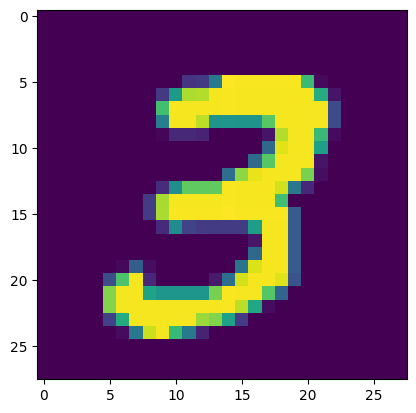

In [6]:
import matplotlib.pyplot as plt

plt.imshow(x_train[0, :, :])
print(y_train[0])

In [7]:
import skimage.measure

x_train = skimage.measure.block_reduce(x_train, (1,7, 7), np.mean)
x_test = skimage.measure.block_reduce(x_test, (1,7,7), np.mean)

x_train.shape




(500, 4, 4)

0


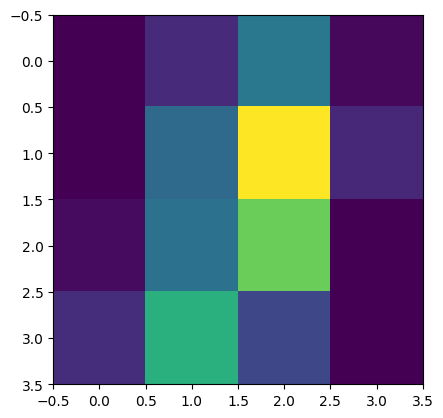

In [8]:
import matplotlib.pyplot as plt

plt.imshow(x_train[0, :, :])
print(y_train[0])

In [9]:
# Flatten image
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1]*x_train.shape[2]))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1]*x_test.shape[2]))

x_test.shape

(500, 16)

### Build classifier


In [10]:
# Convert dataset into a list of MPS
# --------------------------------------
X_train_mps = []
X_test_mps = []

encoding  = 3       # Either 1 or 2

if encoding == 1:
    for i in range(x_test.shape[0]):
        X_train_mps.append(MPS.from_tensor_list(encoding1(x_train[i, :]), conv_params=TNConvergenceParameters()))
        X_test_mps.append(MPS.from_tensor_list(encoding1(x_test[i]), conv_params=TNConvergenceParameters()))
elif encoding == 2:
    for i in range(x_test.shape[0]):
        X_train_mps.append(MPS.from_statevector(x_train[i, :], conv_params=TNConvergenceParameters()))
        X_test_mps.append(MPS.from_statevector(x_test[i], conv_params=TNConvergenceParameters()))
elif encoding == 3:
    for i in range(x_test.shape[0]):
        X_train_mps.append(MPS.from_tensor_list(encoding3(x_train[i, :]), conv_params=TNConvergenceParameters()))
        X_test_mps.append(MPS.from_tensor_list(encoding3(x_test[i]), conv_params=TNConvergenceParameters()))



In [11]:
# Optimize MPS

# get number of sites

# define max bond dimension
if encoding == 1 or encoding == 3:
    num_sites = x_train.shape[1]
elif encoding == 2: 
    num_sites = int(np.log2(x_train.shape[1]))

max_bond = 10

# define batch size, learning rate and number of sweeps
batch_size = 50
learning_rate = 1e-4
num_sweeps = 1000    # epochs

# initialize MPS for the classifier
conv_params = TNConvergenceParameters(
                    max_bond_dimension=max_bond)
tn_classifier = MPS(num_sites, conv_params, dtype=float)

svd, loss = tn_classifier.ml_optimize_mps(X_train_mps,
                                y_train,
                                batch_size=batch_size,
                                learning_rate=learning_rate,
                                num_sweeps=num_sweeps,
                                n_jobs=1,
                                verbose=True)

==================== Sweep 0 started ====================
Sweep loss: 7.5
==================== Sweep 1 started ====================
Sweep loss: 8.4
==================== Sweep 2 started ====================
Sweep loss: 8.1
==================== Sweep 3 started ====================
Sweep loss: 7.2
==================== Sweep 4 started ====================
Sweep loss: 7.2
==================== Sweep 5 started ====================
Sweep loss: 6.9
==================== Sweep 6 started ====================
Sweep loss: 7.5
==================== Sweep 7 started ====================
Sweep loss: 7.5
==================== Sweep 8 started ====================
Sweep loss: 6.9
==================== Sweep 9 started ====================
Sweep loss: 7.8
==================== Sweep 10 started ====================
Sweep loss: 7.5
==================== Sweep 11 started ====================
Sweep loss: 6.6
==================== Sweep 12 started ====================
Sweep loss: 8.7
==================== Sweep 13 start

### Prediction on train and test dataset

In [ ]:
# Predict labels with the trained MPS
y_train_pred = tn_classifier.ml_predict(X_train_mps, n_jobs=1)
y_test_pred = tn_classifier.ml_predict(X_test_mps, n_jobs=1)

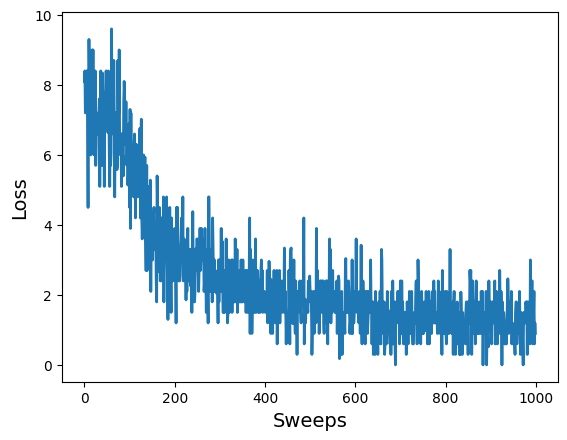

In [22]:
plt.plot(loss, lw = 2)
plt.ylabel('Loss', fontsize=14)
plt.xlabel('Sweeps', fontsize=14)
plt.savefig('loss_enc3.png')

In [215]:
# Get accuracy
accuracy_train = len(np.where(y_train == np.real(y_train_pred))[0]) / len(y_train)
print(accuracy_train)

accuracy_test = len(np.where(y_test == np.real(y_test_pred))[0]) / len(y_test)
print(accuracy_test)

0.788
0.736


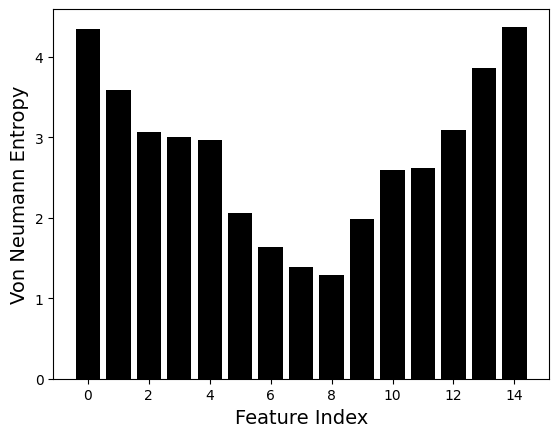

In [26]:
entropy = tn_classifier.meas_bond_entropy()
entropy_l = entropy.values()
x_array = np.arange(len(entropy_l))
plt.bar(x_array, -np.array(list(entropy_l)))
plt.ylabel('Von Neumann Entropy', fontsize = 14)
plt.xlabel('Feature Index', fontsize = 14)
plt.savefig('entropy_enc3.png')


# 

Questions:

* How to interpret the entropy ? 
* Which range of bond dimensions to consider ? 